In [1]:
import numpy as np
import os
import sys
import copy

import torch
from torch import nn

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.insert(0, "../src/")
import data
import model
import train

#import nmrglue as ng
import scipy
import scipy.io

import time

np.random.seed(123)

In [2]:
mod = "PIPNet2D_2022_06_23_random_rot_inv"

in_dir = f"../data/{mod}/"
fig_dir = f"../figures/{mod}/"

overwrite = False

load_model = True

eval_history = True
sel_history = "all"
#sel_history = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
sel_history = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199]

n_samples = 4

eval_evolution = True
#sel_chk = "all"
#sel_chk = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
sel_chk = [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, 159, 169, 179, 189, 199]

vis_filters = False
max_filt = 4
max_smpl = 1

eval_exp = True
exp_dir = "../data/experimental_spectra/"
exp_compounds = ["ampicillin", "tyrosine"]
#x_scales = [0.1, 0.25, 0.5]
x_scales = [0.25]

In [3]:
if not os.path.exists(in_dir):
    raise ValueError(f"Unknown model: {mod}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

In [4]:
def clean_split(l, delimiter):
    """
    Split a line with the desired delimiter, ignoring delimiters present in arrays or strings
    
    Inputs: - l     Input line
    
    Output: - ls    List of sub-strings making up the line
    """
    
    # Initialize sub-strings
    ls = []
    clean_l = ""
    
    # Loop over all line characters
    in_dq = False
    in_sq = False
    arr_depth = 0
    for li in l:
        # Identify strings with double quotes
        if li == "\"":
            if not in_dq:
                in_dq = True
            else:
                in_dq = False
        
        # Identify strings with single quotes
        if li == "\'":
            if not in_sq:
                in_sq = True
            else:
                in_sq = False
        
        # Identify arrays
        if li == "[":
            if not in_sq and not in_dq:
                arr_depth += 1
        if li == "]":
            if not in_sq and not in_dq:
                arr_depth -= 1
        
        # If the delimiter is not within quotes or in an array, split the line at that character
        if li == delimiter and not in_dq and not in_sq and arr_depth == 0:
            ls.append(clean_l)
            clean_l = ""
        else:
            clean_l += li
    
    ls.append(clean_l)
        
    return ls

In [5]:
def get_array(l):
    """
    Get the values in an array contained in a line
    
    Input:  - l         Input line
    
    Output: - vals      Array of values
    """
    
    # Identify empty array
    if l.strip() == "[]":
        return []
    
    # Initialize array
    vals = []
    clean_l = ""
    
    # Loop over all line characters
    arr_depth = 0
    for li in l:
    
        # Identify end of array
        if li == "]":
            arr_depth -= 1
            
            # Check that there are not too many closing brackets for the opening ones
            if arr_depth < 0:
                raise ValueError("Missing \"[\" for matching the number of \"]\"")
        
        # If we are within the array, extract the character
        if arr_depth > 0:
            clean_l += li
    
        # Identify start of array
        if li == "[":
            arr_depth += 1
    
    # Check that the array is properly closed at the end
    if arr_depth > 0:
        raise ValueError("Missing \"]\" for matching the number of \"[\"")
    
    # Extract elements in the array
    ls = clean_split(clean_l, ",")
    
    # Get the value of each element in the array
    for li in ls:
        vals.append(get_val(li.strip()))

    return vals

In [6]:
def get_val(val):
    
    # Remove tailing comma
    if val.endswith(","):
        val = val[:-1]
    
    # Float / Int
    if val.isnumeric():
        
        if "." in val:
            return float(val)
        else:
            return int(val)
    
    # Bool
    if val.lower() == "true":
        return True
    if val.lower() == "false":
        return False
    
    # String
    if val.startswith("\""):
        return val.split("\"")[1]
    
    # List
    if val.startswith("["):
        
        return get_array(val)
    
    # Try to return a float anyway
    return float(val)

In [7]:
# Get model architecture
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

model_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "model_pars = " in l:
        in_pars = True
        continue
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        key, val = L.split("=")
        
        v = get_val(val.strip())
        
        model_pars[key.strip()] = v

model_pars["noise"] = 0.

In [9]:
# Get data parameters
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

data_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "data_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        if "=" in L:
        
            key, val = L.split("=")
        
            v = get_val(val.strip())
        
            data_pars[key.strip()] = v

dataset = data.PIPDatasetGLS2D(data_pars, data_pars, rot_range=[45.])

In [10]:
# Get loss parameters
with open(mod + ".py", "r") as F:
    lines = F.read().split("\n")

loss_pars = {}
in_pars = False

# Parse script
for l in lines:
    
    # Identify model parameter block start
    if "loss_pars = " in l:
        in_pars = True
    
    # Identify model parameter block end
    if l.strip() == ")":
        in_pars = False
    
    if in_pars:
        # Get line
        if "(" in l:
            L = l.split("(")[1].split("#")[0]
        else:
            L = l.strip().split("#")[0]
        
        if "=" in L:
        
            key, val = L.split("=")
        
            v = get_val(val.strip())
        
            loss_pars[key.strip()] = v
            
loss_components = []
loss_components_with_tot = ["Total"]

if "srp_w" in loss_pars and loss_pars["srp_w"] > 0.:
    loss_components.append("Sharp component")
    loss_components_with_tot.append("Sharp component")
if "brd_w" in loss_pars and loss_pars["brd_w"] > 0.:
    loss_components.append("Broad component")
    loss_components_with_tot.append("Broad component")
if "int_w" in loss_pars and loss_pars["int_w"] > 0.:
    loss_components.append("Integral component")
    loss_components_with_tot.append("Integral component")

In [11]:
# Load loss and learning rate
all_lrs = np.load(in_dir + "all_lrs.npy")
all_losses = np.load(in_dir + "all_losses.npy")
all_val_losses = np.load(in_dir + "all_val_losses.npy")

try:
    all_loss_components = np.load(in_dir + "all_loss_components.npy")
    all_val_loss_components = np.load(in_dir + "all_val_loss_components.npy")
    mean_loss_components = np.mean(all_loss_components, axis=1)
    mean_val_loss_components = np.mean(all_val_loss_components, axis=1)
except:
    all_loss_components = None
    all_val_loss_components = None
    mean_loss_components = None
    mean_val_loss_components = None

mean_losses = np.mean(all_losses, axis=1)
mean_val_losses = np.mean(all_val_losses, axis=1)

n_chk = all_losses.shape[0]
best_chk = np.argmin(mean_val_losses)
print(best_chk)

117


In [12]:
with open(f"{fig_dir}params.pk", "wb") as F:
    pk.dump([model_pars, loss_pars, data_pars], F)

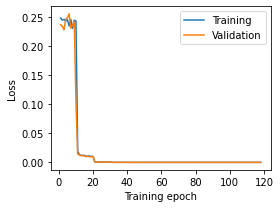

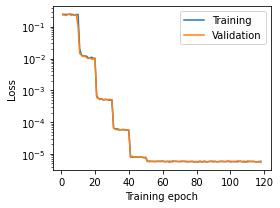

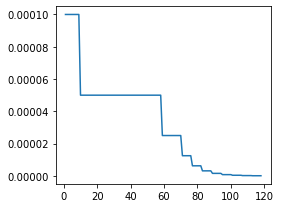

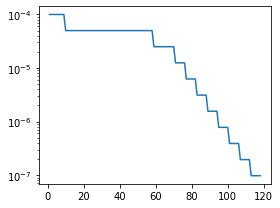

In [13]:
# Plot loss
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), mean_losses)
ax.plot(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss.pdf")

plt.show()
plt.close()

# Plot loss, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), mean_losses)
ax.semilogy(range(1, n_chk+1), mean_val_losses)

ax.set_xlabel("Training epoch")
ax.set_ylabel("Loss")

ax.legend(["Training", "Validation"])

fig.tight_layout()

plt.savefig(fig_dir + "loss_log.pdf")

plt.show()
plt.close()

# Plot learning rate
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.plot(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs.pdf")

plt.show()
plt.close()

# Plot learning rate, log
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)

ax.semilogy(range(1, n_chk+1), np.mean(all_lrs, axis=1))

fig.tight_layout()

plt.savefig(fig_dir + "lrs_log.pdf")

plt.show()
plt.close()

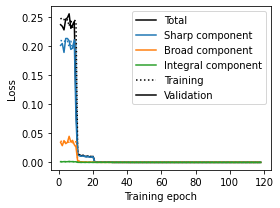

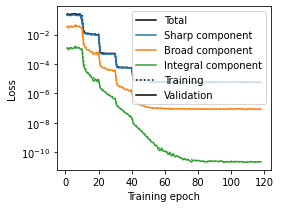

In [14]:
if mean_loss_components is not None:

    # Plot loss components
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_chk+1), mean_losses, f"k:")
    ax.plot(range(1, n_chk+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")
    
    labels = ["Total"]
    labels.extend(loss_components)
    labels.append("Training")
    labels.append("Validation")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components.pdf")

    plt.show()
    plt.close()

    # Plot loss components, log
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)

    hs = []

    ax.plot(range(1, n_chk+1), mean_losses, f"k:")
    ax.plot(range(1, n_chk+1), mean_val_losses, f"k")
    hs.append(mpl.lines.Line2D([0], [0], color=f"k"))

    for i in range(mean_loss_components.shape[-1]):
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i], f"C{i}:")
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i], f"C{i}")
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

    hs.append(mpl.lines.Line2D([0], [0], color="k", linestyle=":"))
    hs.append(mpl.lines.Line2D([0], [0], color="k"))

    ax.set_xlabel("Training epoch")
    ax.set_ylabel("Loss")

    ax.set_yscale("log")

    ax.legend(hs, labels)

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_components_log.pdf")

    plt.show()
    plt.close()

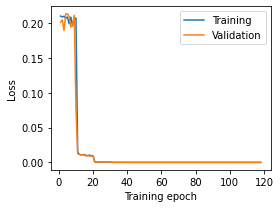

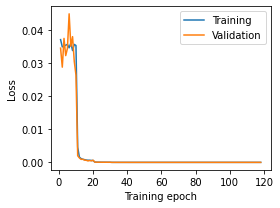

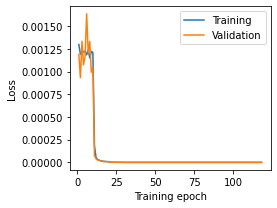

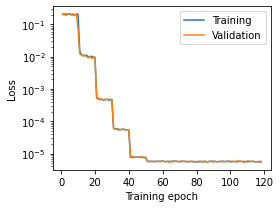

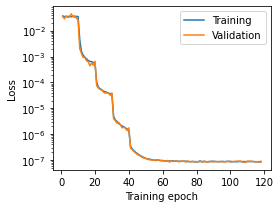

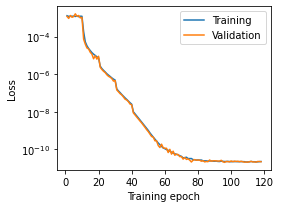

In [15]:
if mean_loss_components is not None:

    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.plot(range(1, n_chk+1), mean_loss_components[:, i])
        ax.plot(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}.pdf")

        plt.show()
        plt.close()
        
    for i in range(mean_loss_components.shape[-1]):
        # Plot loss components
        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)
        
        ax.semilogy(range(1, n_chk+1), mean_loss_components[:, i])
        ax.semilogy(range(1, n_chk+1), mean_val_loss_components[:, i])
        hs.append(mpl.lines.Line2D([0], [0], color=f"C{i}"))

        ax.set_xlabel("Training epoch")
        ax.set_ylabel("Loss")

        ax.legend(["Training", "Validation"])

        fig.tight_layout()

        plt.savefig(fig_dir + f"loss_component_{i}_log.pdf")

        plt.show()
        plt.close()

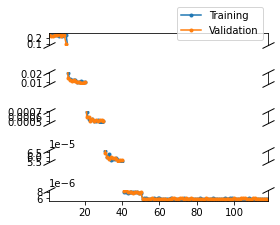

In [16]:
d = 0.5
max_diff = 0.5

mean_losses_dif = np.abs(mean_losses[1:] - mean_losses[:-1])
rel_diffs = mean_losses_dif / mean_losses[:-1]
jumps = np.where(rel_diffs > max_diff)[0]+1

if len(jumps) > 0:

    fig = plt.figure(figsize=(4,3))

    axs = []
    for i in range(len(jumps) + 1):
        axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

        # Plot broken axes markers
        if i > 0:
            axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["top"].set_visible(False)

        if i < len(jumps):
            axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                        markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

            axs[i].spines["bottom"].set_visible(False)
            axs[i].set_xticks([])

        h1 = axs[i].plot(range(1, n_chk+1), mean_losses, ".-")
        h2 = axs[i].plot(range(1, n_chk+1), mean_val_losses, ".-")
        axs[i].set_xlim(1, n_chk)

        if i == 0:
            M = np.max(mean_losses[:jumps[i]])
            M = max(M, np.max(mean_val_losses[:jumps[i]]))
            m = np.min(mean_losses[:jumps[i]])
            m = min(M, np.min(mean_val_losses[:jumps[i]]))

        elif i == len(jumps):
            M = np.max(mean_losses[jumps[i-1]:])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:]))
            m = np.min(mean_losses[jumps[i-1]:])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:]))

        else:
            M = np.max(mean_losses[jumps[i-1]:jumps[i]])
            M = max(M, np.max(mean_val_losses[jumps[i-1]:jumps[i]]))
            m = np.min(mean_losses[jumps[i-1]:jumps[i]])
            m = min(m, np.min(mean_val_losses[jumps[i-1]:jumps[i]]))

        r = M - m

        axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

    axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

    fig.tight_layout()

    plt.savefig(fig_dir + "loss_split.pdf")

    plt.show()
    plt.close()

Loss component 0:
Training loss minimum: 5.463e-06, mean over 10 last epochs: 5.636e-06
Validation loss minimum: 5.330e-06, mean over 10 last epochs: 5.633e-06



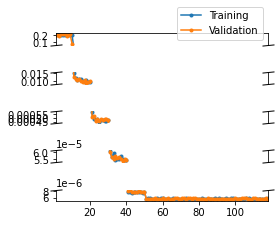

Loss component 1:
Training loss minimum: 8.425e-08, mean over 10 last epochs: 8.676e-08
Validation loss minimum: 8.123e-08, mean over 10 last epochs: 8.653e-08



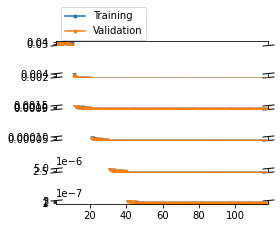

Loss component 2:
Training loss minimum: 2.168e-11, mean over 10 last epochs: 2.225e-11
Validation loss minimum: 2.064e-11, mean over 10 last epochs: 2.219e-11



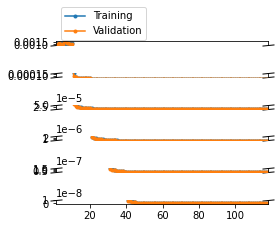

In [17]:
d = 0.1
max_diff = 0.5

if mean_loss_components is not None:

    for k in range(mean_loss_components.shape[-1]):
        
        pp = f"Loss component {k}:\n"
        
        pp += "Training loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_loss_components[:, k]), np.mean(mean_loss_components[-10:, k]))
        pp += "Validation loss minimum: {:.3e}, mean over 10 last epochs: {:.3e}\n".format(np.min(mean_val_loss_components[:, k]), np.mean(mean_val_loss_components[-10:, k]))
        print(pp)
        
        with open(f"{fig_dir}loss_component_{k}_summary.txt", "w") as F:
            F.write(pp)

        diffs = np.abs(mean_loss_components[1:, k] - mean_loss_components[:-1, k])
        rel_diffs = diffs / mean_loss_components[:-1, k]
        jumps = np.where(rel_diffs > max_diff)[0]+1
        
#        jumps = [jumps[-1]]
        #jumps = [50]

        if len(jumps) > 0:

            fig = plt.figure(figsize=(4,3))

            axs = []
            for i in range(len(jumps) + 1):
                axs.append(fig.add_subplot(len(jumps)+1, 1,i+1))

                # Plot broken axes markers
                if i > 0:
                    axs[i].plot([0, 1], [1, 1], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["top"].set_visible(False)

                if i < len(jumps):
                    axs[i].plot([0, 1], [0, 0], transform=axs[i].transAxes, marker=[(-1, -d), (1, d)],
                                markersize=12, linestyle="none", color="k", mec="k", mew=1, clip_on=False)

                    axs[i].spines["bottom"].set_visible(False)
                    axs[i].set_xticks([])

                h1 = axs[i].plot(range(1, n_chk+1), mean_loss_components[:, k], ".-")
                h2 = axs[i].plot(range(1, n_chk+1), mean_val_loss_components[:, k], ".-")
                axs[i].set_xlim(1, n_chk)

                if i == 0:
                    M = np.max(mean_loss_components[:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[:jumps[i], k]))
                    m = np.min(mean_loss_components[:jumps[i], k])
                    m = min(M, np.min(mean_val_loss_components[:jumps[i], k]))

                elif i == len(jumps):
                    M = np.max(mean_loss_components[jumps[i-1]:, k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:, k]))
                    m = np.min(mean_loss_components[jumps[i-1]:, k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:, k]))

                else:
                    M = np.max(mean_loss_components[jumps[i-1]:jumps[i], k])
                    M = max(M, np.max(mean_val_loss_components[jumps[i-1]:jumps[i], k]))
                    m = np.min(mean_loss_components[jumps[i-1]:jumps[i], k])
                    m = min(m, np.min(mean_val_loss_components[jumps[i-1]:jumps[i], k]))

                r = M - m

                axs[i].set_ylim(m - 0.1 * r, M + 0.1 * r)

            axs[0].legend([h1[0], h2[0]], ["Training", "Validation"])

            fig.tight_layout()

            plt.savefig(fig_dir + f"loss_component_{k}_split.pdf")

            plt.show()
            plt.close()

# Evaluate the model history

In [18]:
def plot_checkpoint(X, y_trg, y_pred, y_std, ys=None, input_factor=0.5, show=True, save=None, anim=False, all_steps=False,
                    c_start=[0., 1., 1.], c_stop=[0., -1., 0.], c2_start=[1., 1., 0.], c2_stop=[0., -1., 0.], plot_proj=True, proj_thresh=0.02):
    
    if y_std is None:
        y_std = [[] for _ in range(X.shape[0])]
    
    n_pts = X.shape[-1]
    
    n = X.shape[1] - 1
    
    colors = [[c0 + (i / n) * c1 for c0, c1 in zip(c_start, c_stop)] for i in range(n+1)]
    
    if ys is not None:
        n2 = ys.shape[0] - 1
        colors2 = [[c0 + (i / n2) * c1 for c0, c1 in zip(c2_start, c2_stop)] for i in range(n2+1)]
    
    # Plot 2D 
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
        
        for k in range(yi_pred.shape[0]):
            
            if all_steps or k == yi_pred.shape[0] - 1:

                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                h1 = ax.contour(yi_trg[0], linewidths=1., levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Greys")
                
                if np.max(yi_pred[k]) > 0.001 and np.min(yi_pred[k]) < 0.005:
                    h2 = ax.contour(yi_pred[k], linewidths=1., levels=[0.001, 0.002, 0.003, 0.004, 0.005], cmap="Reds")

                    ax.legend([h1.legend_elements()[0][-1], h2.legend_elements()[0][-1]], ["Ground-truth", "Prediction"])
                
                else:
                    ax.legend([h1.legend_elements()[0][-1]], ["Ground-truth\n(prediction out of range)"])

                fig.tight_layout()

                if save is not None:
                    plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}.pdf")
                
                if show:
                    plt.show()

                plt.close()
    
    if not plot_proj:
        return

    # Plot 1D projections
    for i, (Xi, yi_trg, yi_pred, yi_std) in enumerate(zip(X, y_trg, y_pred, y_std)):
        
        for k in range(yi_pred.shape[0]):
            
            if all_steps or k == yi_pred.shape[0] - 1:

                rows, cols = np.where(yi_trg[0] > proj_thresh)

                for row in np.unique(rows):
                    # Print target vs. pred
                    fig = plt.figure(figsize=(4,3))
                    ax = fig.add_subplot(1,1,1)

                    ax.plot(yi_trg[0, row], linewidth=1.)
                    ax.plot(yi_pred[k, row], linewidth=1.)

                    if len(yi_std) > 0:
                        ax.fill_between(range(n_pts), yi_pred[k, row] - yi_std[k, row], yi_pred[k, row] + yi_std[k, row], facecolor="C1", alpha=0.3)

                    ax.legend(["Ground-truth", "Prediction"])

                    fig.tight_layout()

                    if save is not None:
                        plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}_row_{row}.pdf")
                    
                    if show:
                        plt.show()

                    plt.close()

                for col in np.unique(cols):
                    # Print target vs. pred
                    fig = plt.figure(figsize=(4,3))
                    ax = fig.add_subplot(1,1,1)

                    ax.plot(yi_trg[0, :, col], linewidth=1.)
                    ax.plot(yi_pred[k, :, col], linewidth=1.)

                    if len(yi_std) > 0:
                        ax.fill_between(range(n_pts), yi_pred[k, :, col] - yi_std[k, :, col], yi_pred[k, :, col] + yi_std[k, :, col], facecolor="C1", alpha=0.3)

                    ax.legend(["Ground-truth", "Prediction"])

                    fig.tight_layout()

                    if save is not None:
                        plt.savefig(save + f"sample_{i+1}_pred_step_{k+1}_col_{col}.pdf")
                    
                    if show:
                        plt.show()

                    plt.close()
        
    return

In [19]:
if eval_history:

    fdir = fig_dir + "eval_history/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if (sel_history == "all" or i in sel_history) and os.path.exists(in_dir + f"checkpoint_{i+1}_in.npy"):

            print(f"Checkpoint {i+1}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)

            if overwrite or not os.path.exists(d + "sample_1_pred_step_6.pdf"):

                X = np.load(in_dir + f"checkpoint_{i+1}_in.npy")
                y_trg = np.load(in_dir + f"checkpoint_{i+1}_trg.npy")
                y_pred = np.load(in_dir + f"checkpoint_{i+1}_pred.npy")
                y_std = np.load(in_dir + f"checkpoint_{i+1}_std.npy")

                plot_checkpoint(X, y_trg, y_pred, y_std, anim=True, all_steps=False, show=False, save=d, plot_proj=False)

print("All done!")

Checkpoint 1...
Checkpoint 10...
Checkpoint 20...
Checkpoint 30...
Checkpoint 40...
Checkpoint 50...
Checkpoint 60...
Checkpoint 70...
Checkpoint 80...
Checkpoint 90...
Checkpoint 100...
Checkpoint 110...
All done!


# Load model and generate dataset

In [20]:
if eval_evolution or eval_exp:

    net = model.ConvLSTMEnsemble(**model_pars)
    net.eval()
    
    if eval_evolution:

        X = []
        y = []

        for i in range(n_samples):
            _, _, Xi, _, _, yi = dataset.__getitem__(0)
            X.append(Xi.unsqueeze(0))
            y.append(yi.unsqueeze(0))

        X = torch.cat(X, dim=0)
        y = torch.cat(y, dim=0)

In [21]:
def print_filter(X, filt, f_inds, max_smpl=-1, encode_mas=False, show=True, save=None, xl=[0., 1.], yl=[0., 1.], sig=True):
    
    c0 = np.array([0., 1., 1.])
    dc = np.array([0.,-1., 0.])

    n_filt = len(f_inds)
    n_smpl = X.shape[0]
    if max_smpl > 0:
        n_smpl = min(n_smpl, max_smpl)
    n_pts = X.shape[-1]
    n_row = int(np.sqrt(n_filt))
    n_col = int(n_filt / n_row)
    n_col += 1 if (n_filt / n_row) > int(n_filt / n_row) else 0
    
    for sample in range(n_smpl):
        
        # Filter as color

        fig = plt.figure(figsize=(5*n_col,3*n_row))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))

        if sig:
            for i, f_ind in enumerate(f_inds):
                
                if i % n_col != 0:
                    axs[i].set_yticks([])
                
                if int(i / n_row + 1) < n_row:
                    axs[i].set_xticks([])
                    
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="Blues", marker=".", vmin=vmin, vmax=vmax)

                fig.colorbar(cb, ax=axs[i])

        else:
            for i, f_ind in enumerate(f_inds):
                
                vmin = torch.min(filt[sample, f_ind])
                vmax = torch.max(filt[sample, f_ind])
                for xi in X[sample]:
                    cb = axs[i].scatter(range(n_pts), xi, s=5, c=filt[sample, f_ind],
                                        cmap="jet", marker=".", vmin=vmin, vmax=vmax)
                    
                fig.colorbar(cb, ax=axs[i])
                        
        for i in range(n_filt):
            axs[i].set_xlim(xl)
            axs[i].set_ylim(yl)
            
        fig.tight_layout()
        
        if show:
            plt.show()
        
        if save is not None:
            plt.savefig(save + f"_sample_{sample+1}.pdf")
            
        plt.close()
        
        # Filter as spectrum
        
        fig = plt.figure(figsize=(5*n_col,3*n_row))
        axs = []
        for row in range(n_row):
            for col in range(n_col):
                axs.append(fig.add_subplot(n_row,n_col,(row * n_col) + col + 1))

        for i, f_ind in enumerate(f_inds):
            
            hs = []

            for k, xi in enumerate(X[sample]):
                h = axs[i].plot(range(n_pts), xi, c=c0 + (k / (X[sample].shape[0]-1) * dc))
            hs.append(h[0])
            
            h = axs[i].plot(range(n_pts), filt[sample, f_ind], "C1")
            hs.append(h[0])
                        
        for i in range(n_filt):
            axs[i].legend(hs, ["Input", "Output"])
            
        fig.tight_layout()
        
        if show:
            plt.show()
        
        if save is not None:
            plt.savefig(save + f"_sample_{sample+1}_filt.pdf")
            
        plt.close()
    
    return

In [22]:
def get_filt_inds(all_filt, max_filt=-1):
    
    filt = torch.cat(all_filt, dim=0)
    
    df = torch.max(filt[:, :, 50:-50], axis=-1)[0] - torch.min(filt[:, :, 50:-50], axis=-1)[0]
    df = torch.max(df, dim=0)[0]
    
    f_inds = torch.argsort(df, descending=True)
    
    return f_inds[:max_filt]

In [23]:
if vis_filters:
    fdir = fig_dir + "vis_filters/"
    
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
    
    if not os.path.exists(fdir):
        os.mkdir(fdir)
        
    xl = [-1, X.shape[-1]]
    dy = (torch.max(X[:, :, 0, :]) - torch.min(X[:, :, 0, :])) * 0.05
    yl = [torch.min(X[:, :, 0, :]) - dy, torch.max(X[:, :, 0, :]) + dy]

    for ind_model, model in enumerate(net.models):
        
        mdir = fdir + f"model_{ind_model+1}/"
    
        if not os.path.exists(mdir):
            os.mkdir(mdir)

        print(f"Model {ind_model+1}/{len(net.models)}...")
        X_vis = net.models[ind_model]._batch_input(X[:, :, :1, :])
        
        for ind_layer in range(len(net.models[ind_model].cell_list)):
            
            ldir = mdir + f"layer_{ind_layer+1}/"
    
            if not os.path.exists(ldir):
                os.mkdir(ldir)
            
            # Initialize state and batch input
            hidden_state = net.models[ind_model]._init_hidden(batch_size=X.shape[0], image_size=X.shape[-1])
            cur_layer_input = net.models[ind_model]._batch_input(X)

            # Run previous layers
            if ind_layer > 0:
                for prev_layer in range(ind_layer):
                    h, c = hidden_state[prev_layer]
                    output_inner = []
                    for t in range(cur_layer_input.shape[1]):
                        h, c = net.models[ind_model].cell_list[prev_layer].forward(cur_layer_input[:, t, :, :], cur_state=[h, c])
                        output_inner.append(h)
                    cur_layer_input = torch.stack(output_inner, dim=1)

            print(f"  Cell {ind_layer+1}/{len(net.models[ind_model].cell_list)}...")
            h, c = hidden_state[ind_layer]
            
            all_i = []
            all_f = []
            all_o = []
            all_g = []
            all_h = []
            all_c = []

            for t in range(cur_layer_input.shape[1]):
                i, f, o, g, h, c = net.models[ind_model].cell_list[ind_layer].analyze(cur_layer_input[:, t], [h, c])
                
                all_i.append(i.detach().clone())
                all_f.append(f.detach().clone())
                all_g.append(g.detach().clone())
                all_h.append(h.detach().clone())
                all_c.append(c.detach().clone())
                
                if not model_pars["independent"]:
                    all_o.append(o.detach().clone())
                else:
                    all_o.append(None)
            
            for t, (i, f, o, g, h, c) in enumerate(zip(all_i, all_f, all_o, all_g, all_h, all_c)):
                
                print(f"    State {t+1}/{cur_layer_input.shape[1]}...")

                if overwrite or f"i_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing input gate...")
                    i_inds = get_filt_inds(all_i, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), i.detach().clone(), i_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}i_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"f_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing forget gate...")
                    f_inds = get_filt_inds(all_f, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), f.detach().clone(), f_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}f_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if not model_pars["independent"] and (overwrite or f"o_{t+1}_sample_1.pdf" not in os.listdir(ldir)):
                    print("      Printing output gate...")
                    o_inds = get_filt_inds(all_o, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), o.detach().clone(), o_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}o_{t+1}", xl=xl, yl=yl, sig=True)
                    
                if overwrite or f"g_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing cell state update...")
                    g_inds = get_filt_inds(all_g, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), g.detach().clone(), g_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}g_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"h_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing LSTM output...")
                    h_inds = get_filt_inds(all_h, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), h.detach().clone(), h_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}h_{t+1}", xl=xl, yl=yl, sig=False)
                    
                if overwrite or f"c_{t+1}_sample_1.pdf" not in os.listdir(ldir):
                    print("      Printing cell state...")
                    c_inds = get_filt_inds(all_c, max_filt=max_filt)
                    print_filter(X_vis[:, t].detach().clone(), c.detach().clone(), c_inds, max_smpl=max_smpl,
                                 encode_mas=data_pars["encode_w"], show=False,
                                 save=f"{ldir}c_{t+1}", xl=xl, yl=yl, sig=False)

print("All done!")

All done!


In [23]:
if eval_evolution:

    fdir = fig_dir + "eval_evolution/"

    if not os.path.exists(fdir):
        os.mkdir(fdir)

    for i in range(n_chk):
        
        if (sel_chk == "all" or i in sel_chk) and os.path.exists(in_dir + f"checkpoint_{i+1}_network"):

            print(f"Checkpoint {i+1}/{n_chk}...")

            d = fdir + f"checkpoint_{i+1}/"
            if not os.path.exists(d):
                os.mkdir(d)
            
            if overwrite or not os.path.exists(d + "sample_1_input.pdf"):

                print("  Loading model...")
                net.load_state_dict(torch.load(in_dir + f"checkpoint_{i+1}_network", map_location=torch.device("cpu")))
                net.eval()

                print("  Performing predictions...")
                y_pred, y_std, ys = net(X)
                y_pred = y_pred.detach().numpy()
                y_std = y_std.detach().numpy()
                ys = ys.detach().numpy()

                print("  Plotting data...")
                plot_checkpoint(X.numpy(), y.numpy(), y_pred, y_std, anim=True, all_steps=True, show=False, save=d, plot_proj=False)
        
print("All done!")

Checkpoint 1/120...
  Loading model...
  Performing predictions...


KeyboardInterrupt: 

# Evaluate experimental data

In [24]:
def load_2d_spectrum(exp_dir, compound, norm=True):
    
    for f in os.listdir(exp_dir):
        if f.startswith(compound):
            m = scipy.io.loadmat(exp_dir + f)
    
    X = m["newsignal2"].transpose(2, 0, 1)
    
    if norm:
        for i in range(X.shape[0]):
            X[i] /= np.sum(X[i])
    
    ws = m["wr"][0]
    inds = np.argsort(ws)
    
    return X[inds], ws[inds]

In [25]:
def make_input(X, ws, data_pars, Xi=None, x_max=0.25):
    
    inds = np.argsort(ws)
    X_torch = torch.Tensor(X[inds])
    
    X_torch = torch.unsqueeze(X_torch, dim=0)
    X_torch = torch.unsqueeze(X_torch, dim=2)
    
    M = torch.max(X_torch)
    
    X_torch /= M
    X_torch *= x_max
    
    if data_pars["encode_w"]:
        W = torch.Tensor(ws[inds])
        W = torch.unsqueeze(W, dim=0)
        W = torch.unsqueeze(W, dim=2)
        W = torch.unsqueeze(W, dim=3)
        W = torch.unsqueeze(W, dim=4)
        W = W.repeat(1, 1, 1, X_torch.shape[-2], X_torch.shape[-1])
        
        if data_pars["norm_wr"]:
            W -= data_pars["mas_w_range"][0]
            W /= data_pars["mas_w_range"][1] - data_pars["mas_w_range"][0]
        elif data_pars["wr_inv"]:
            W = data_pars["wr_factor"] / W
    
    if Xi is not None:
        X_imag = torch.Tensor(Xi[inds])
        X_imag = torch.unsqueeze(X_imag, dim=0)
        X_imag = torch.unsqueeze(X_imag, dim=2)
        X_imag /= M
        X_imag *= x_max
        
        X_torch = torch.cat([X_torch, X_imag, W], dim=2)
    
    else:
        X_torch = torch.cat([X_torch, W], dim=2)
    
    return X_torch, ws[inds]

In [26]:
def plot_exp_vs_pred(X, y_pred, ymin=0.1, ymax=1., show=True, save=None, c0=[0., 1., 1.], dc=[0., -1., 0.], proj_thresh=0.1, plot_1d=True):
    
    # Plot 2D 
    n = y_pred.shape[0]

    for k in range(y_pred.shape[0]):

        fig = plt.figure(figsize=(4,3))
        ax = fig.add_subplot(1,1,1)

        h1 = ax.contour(X[(-n)+k] / np.max(X[(-n)+k]), linewidths=0.5, levels=np.linspace(ymin, ymax, 50), colors="C0")

        h2 = ax.contour(y_pred[k] / np.max(y_pred[k]), linewidths=0.5, levels=np.linspace(ymin, ymax, 50), colors="C1")

        ax.legend([h1.legend_elements()[0][-1], h2.legend_elements()[0][-1]], ["Experiment", "Prediction"], loc="upper left")

        fig.tight_layout()

        if save is not None:
            plt.savefig(f"{save}_pred_step_{k+1}.pdf")

        if show:
            plt.show()

        plt.close()
    
    if plot_1d:

        # Plot 1D projections
        for k in range(y_pred.shape[0]):

            rows, cols = np.where(X[(-n)+k] > proj_thresh)

            for row in np.unique(rows):
                # Print target vs. pred
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                ax.plot(X[(-n)+k, row] / np.max(X[(-n)+k]), linewidth=1.)
                ax.plot(y_pred[k, row] / np.max(y_pred[k]), linewidth=1.)

                ax.legend(["Experiment", "Prediction"])

                ax.set_ylim(-0.1, 1.1)

                fig.tight_layout()

                if save is not None:
                    plt.savefig(f"{save}_pred_step_{k+1}_row_{row}.pdf")

                if show:
                    plt.show()

                plt.close()

            for col in np.unique(cols):
                # Print target vs. pred
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)

                ax.plot(X[(-n)+k, :, col] / np.max(X[(-n)+k]), linewidth=1.)
                ax.plot(y_pred[k, :, col] / np.max(y_pred[k]), linewidth=1.)

                ax.legend(["Ground-truth", "Prediction"])

                ax.set_ylim(-0.1, 1.1)

                fig.tight_layout()

                if save is not None:
                    plt.savefig(save + f"_pred_step_{k+1}_col_{col}.pdf")

                if show:
                    plt.show()

                plt.close()
    
    return

In [27]:
import importlib
mpl.use("agg")
importlib.reload(mpl)
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/manuelcordova/opt/anaconda3/envs/PIPNet/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [28]:
best_chk = min(round(best_chk / 10) * 10 - 1, 99)

In [ ]:
if eval_exp:
    
    # Load best model
    net.load_state_dict(torch.load(in_dir + f"checkpoint_{best_chk+1}_network", map_location=torch.device("cpu")))
        
    for xscale in x_scales:
        
        fdir = fig_dir + f"eval_exp_scale_{xscale}/"
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        
        for compound in exp_compounds:
            print(compound)
            
            X, ws = load_2d_spectrum(exp_dir, compound)
            X_torch, ws = make_input(X, ws, data_pars, x_max=xscale)

            t1 = time.time()
            with torch.no_grad():
                y_pred, y_std, ys = net(X_torch)
            t2 = time.time()
            print(t2-t1)
            
            y_pred = y_pred.detach().numpy()[0]
            
            plot_exp_vs_pred(X / np.max(X), y_pred, ymin=0.05, ymax=1., show=False, save=f"{fdir}{compound}", plot_1d=False)
            
            scipy.io.savemat(fdir + f"preds_{compound}.mat", {"preds": y_pred})
            
            for i in range(model_pars["batch_input"], X_torch.shape[1]):
                t1 = time.time()
                with torch.no_grad():
                    y_pred, y_std, ys = net(X_torch[:, -i:])
                t2 = time.time()
                print(t2-t1)

                y_pred = y_pred.detach().numpy()[0]

                plot_exp_vs_pred(X / np.max(X), y_pred, ymin=0.05, ymax=1., show=False, save=f"{fdir}{compound}_highest_{i}", plot_1d=False)

                scipy.io.savemat(fdir + f"preds_{compound}_highest_{i}.mat", {"preds": y_pred})

ampicillin
193.22333312034607
39.63750910758972
71.25910568237305
110.30646014213562
125.20768713951111
165.5296061038971
tyrosine
292.51027512550354
23.779886960983276
63.69828414916992
72.57010197639465
103.85063004493713
118.06249904632568
137.85809779167175
162.3543508052826
200.47285413742065
222.3023509979248
233.70903396606445
